<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [30]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [31]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 parse_dates=['created'])
# changed 'created' column to datetime dtype ^

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [32]:
# Sorting the 'created' column by date
df = df.sort_values(by='created')

In [33]:
# Changed index to the 'created' column
df = df.set_index('created')

In [34]:
print(df.shape)
df.head()

(48817, 33)


,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-04-01 22:12:41 to 2016-06-29 21:41:47
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

In [36]:
df.isnull().sum()
# Null values only in columns with strings, should be ok

bathrooms                  0
bedrooms                   0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
dtype: int64

In [41]:
# Creating two engineered features:

# 1) Total number of rooms (bathrooms + bedrooms):
df['total_rooms'] = (df['bathrooms'] + df['bedrooms'])

# 2) Total perks apartment has:
df['total_perks'] = (df['elevator'] + df['hardwood_floors'] + df['doorman'] + 
                     df['dishwasher'] + df['fitness_center'] + df['pre-war'] + 
                     df['laundry_in_unit'] + df['roof_deck'] + 
                     df['outdoor_space'] + df['dining_room'] 
                     + df['high_speed_internet'] + df['balcony'] + df['swimming_pool'] 
                     + df['new_construction'] + df['terrace'] + df['exclusive'] + 
                     df['loft'] + df['garden_patio'] + df['wheelchair_access']) 
# didn't include laundry in building since already have laundry in unit, also 
# excluded common outdoor space due to already having outdoor space

print(df.shape)
df.head()

(48817, 35)


,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,total_perks
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.0,4
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.0,4
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2


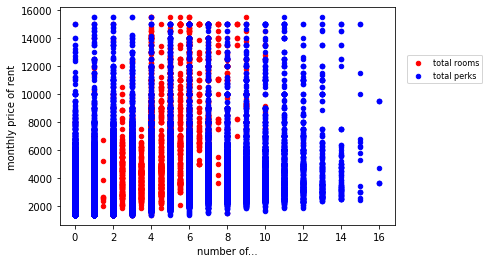

In [52]:
import matplotlib.pyplot as plt

ax = df.plot(kind='scatter',x='total_rooms',y='price',color='red')
df.plot(kind='scatter', x='total_perks', y='price', color='blue', ax=ax)

ax.legend(['total rooms', 'total perks'], loc='upper center', 
          bbox_to_anchor=(1.15, 0.8), fontsize=8)

plt.xlabel('number of...')
plt.ylabel('monthly price of rent')

plt.show()

# definitely can see positive linear correlation with total rooms,
# maybe not as much with total perks

In [54]:
# Splitting data:

# target vector =
y = df['price']

# feature matrix =
X = df[['total_rooms', 'total_perks']] 


In [65]:
print(df.index)

DatetimeIndex(['2016-04-01 22:12:41', '2016-04-01 22:56:00',
               '2016-04-01 22:57:15', '2016-04-01 23:26:07',
               '2016-04-02 00:48:13', '2016-04-02 01:11:13',
               '2016-04-02 01:11:30', '2016-04-02 01:11:31',
               '2016-04-02 01:11:34', '2016-04-02 01:11:40',
               ...
               '2016-06-29 17:32:19', '2016-06-29 17:35:09',
               '2016-06-29 17:37:20', '2016-06-29 17:38:02',
               '2016-06-29 17:39:08', '2016-06-29 17:47:34',
               '2016-06-29 17:56:12', '2016-06-29 18:14:48',
               '2016-06-29 18:30:41', '2016-06-29 21:41:47'],
              dtype='datetime64[ns]', name='created', length=48817, freq=None)


In [58]:
# training and test sets = 

# Training on April and May 2016:
mask_train = ((X.index >= '2016-04-01 00:00:00') & (X.index < '2016-06-01 00:00:00'))

# Testing on June 2016:
mask_test = ((X.index >= '2016-06-01 00:00:00') & (X.index < '2016-07-01 00:00:00'))

X_train, y_train = X.loc[mask_train], y.loc[mask_train]
X_test, y_test = X.loc[mask_test], y.loc[mask_test]

In [63]:
assert len(X) == len(X_train) + len(X_test)

In [67]:
# Establishing Baseline:

from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 1201.8811133682555


In [69]:
# Building Model:

# 1) Importing the predictor
from sklearn.linear_model import LinearRegression

# 2) Instantiating the predictor
model = LinearRegression()

# 3) Fitting the model to the training data
model.fit(X_train[['total_rooms', 'total_perks']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
# Slope (2 parameters here)
print(model.coef_)

# Intercept
print(model.intercept_)

# Equation for the plane of best fit:
# y = 1071 + (766 * x1) + (123 * x2)

[766.29069701 123.31071079]
1071.3368150759738


In [91]:
# 4) Make predictions

def prediction(rooms, perks):
  print('Monthly rental price prediction for a NYC apartment with', int(rooms), 'rooms and', int(perks), 'perks:', (*model.predict([[rooms, perks]])), 'dollars.')

In [92]:
# Example prediction:

prediction(10,10)

Monthly rental price prediction for a NYC apartment with 10 rooms and 10 perks: 9967.350893064255 dollars.


In [ ]:
# Checking metrics

In [71]:
# Mean Absolute Error:

print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train[['total_rooms', 'total_perks']])))
print('Testing MAE:', mean_absolute_error(y_test, model.predict(X_test[['total_rooms', 'total_perks']])))

# Both lower than the baseline!

Training MAE: 856.2258991561976
Testing MAE: 867.5464330673303


In [72]:
# Root Mean Squared Error:

from sklearn.metrics import mean_squared_error

print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train[['total_rooms', 'total_perks']]), squared=False))
print('Testing RMSE:', mean_squared_error(y_test, model.predict(X_test[['total_rooms', 'total_perks']]), squared=False))

Training RMSE: 1291.3944204612842
Testing RMSE: 1289.4766107505095


In [73]:
# R**2 Score:

from sklearn.metrics import r2_score

print('Training R^2:', r2_score(y_train, model.predict(X_train[['total_rooms', 'total_perks']])))
print('Testing R^2:', r2_score(y_test, model.predict(X_test[['total_rooms', 'total_perks']])))

Training R^2: 0.46290357698225937
Testing R^2: 0.4650133360182984


In [75]:
# ...A more efficient way of calculating R**2 Score:

print('Training R^2:', model.score(X_train, y_train))
print('Testing R^2:', model.score(X_test, y_test))

Training R^2: 0.46290357698225937
Testing R^2: 0.4650133360182984
